In [34]:
%matplotlib inline
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
from utils.metrics import *

width = 6
height = 4
plt.figure(figsize=(width,height))
sns.set(rc={"figure.figsize":(width, height)})
root_baseline_data_path = '../output/%s/%s/%s/'
seq_len = 96

def load(path):
    with open(path, 'wr') as f:
        return pkl.load(f)


def get_borders(data_name, data_len):
    border1s = [0, 12 * 30 * 24 * 4 - seq_len, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4 - seq_len]
    border2s = [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 8 * 30 * 24 * 4]

    if data_name.find('ett') != -1:
        return border1s, border2s

    num_train = int(data_len * 0.7)
    num_test = int(data_len * 0.2)
    num_vali = data_len - num_train - num_test
    border1s = [0, num_train - seq_len, data_len - num_test - seq_len]
    border2s = [num_train, num_train + num_vali, data_len]

    return border1s, border2s


def get_eb(exp_str):
    eb = re.findall('eb[_.0-9]+', exp_str)[0]
    eb = eb.replace('eb', '')
    eb = eb.replace('_', '')
    eb = float(eb)
    if eb >= 1:
        eb *= 0.01

    return eb


def load(path):
    with open(path, 'rb') as f:
        return pkl.load(f)


def metrics_ensemble(pred, true):
    mae = MAE(pred, true)
    rmse = RMSE(pred, true)
    rse = RSE(pred, true)
    nrmse = NRMSE(pred, true)
    corr = CORR(pred, true)
    psnr = PSNR(pred, true)

    return {'mae': mae,
            'rmse': rmse,
            'nrmse': nrmse,
            'rse': rse,
            'corr': corr,
            'psnr': psnr}


def load_pkl(path):
    with open(path, 'rb') as f:
        return pkl.load(f)


def get_baseline(model:str, data:str):
    raw_data_path = root_baseline_data_path%(model, data, 'raw') + 'true.pkl'
    raw_data = load(raw_data_path)

    predictions_path = root_baseline_data_path%(model, data, 'raw') + 'output.pkl'
    pred_data = load(predictions_path)
    results = metrics_ensemble(pred_data, raw_data)
    df = pd.DataFrame(results, index=[0.0])
    df.index.name = 'eb'
    return df


def get_forecasting_results(model: str, data_file: str, data_name: str,
                            eblc_name: str, target_ot: str, ebs_values: tuple):
    df = pd.read_parquet(f'../data/compressed/{eblc_name}/{data_file}')
    metrics = []
    ebs = []
    border1s, border2s = get_borders(data_name, len(df))
    raw_df = df[f'{target_ot}-R'].values[border1s[2]:border2s[2]]
    for eb in ebs_values:
        decomp_target_var = df[[f'{target_ot}-E{eb}']].values[border1s[2]:border2s[2]][:, 0]
        results = metrics_ensemble(decomp_target_var, raw_df)
        metrics.append(results)
        ebs.append(eb)

    df = pd.DataFrame(metrics)
    df['eb'] = ebs
    dec_error = df.groupby(['eb']).median()
    dec_error.plot()
    plt.show()

    raw_data_path = root_baseline_data_path%(model, data_name, 'raw') + 'true.pkl'
    raw_data = load(raw_data_path)

    metrics = []
    ebs = []
    for root, dr, files in os.walk(root_baseline_data_path%(model, data_name, eblc_name)+ 'predictions'):
        for file in files:
            results = metrics_ensemble(load(root+os.sep+file), raw_data)
            metrics.append(results)
            ebs.append(get_eb(file))

    df = pd.DataFrame(metrics)
    df['eb'] = ebs
    forecasting_results = df.groupby(['eb']).median()
    forecasting_results.sort_index(inplace=True)
    return forecasting_results, dec_error


def concat_baseline_forecasting_result(baseline_results, forecasting_results, dec_error):
    concat_forecasting_results = pd.concat([baseline_results, forecasting_results], axis=0)
    metric_indexed_results = pd.DataFrame()
    metric_indexed_results['error'] = [0.0]+list(dec_error['mae'].values)
    metric_indexed_results['mae'] = concat_forecasting_results['mae'].values
    metric_indexed_results['rmse'] = concat_forecasting_results['rmse'].values
    metric_indexed_results['nrmse'] = concat_forecasting_results['nrmse'].values
    metric_indexed_results['rse'] = concat_forecasting_results['rse'].values
    metric_indexed_results['corr'] = concat_forecasting_results['corr'].values
    metric_indexed_results['data_corr'] = [1.0]+list(dec_error['corr'].values)
    metric_indexed_results.set_index('error', inplace=True)
    metric_indexed_results['eb'] = [0.0]+list(dec_error.index)
    sns.lineplot(data=metric_indexed_results)
    plt.show()
    return concat_forecasting_results



<Figure size 432x288 with 0 Axes>

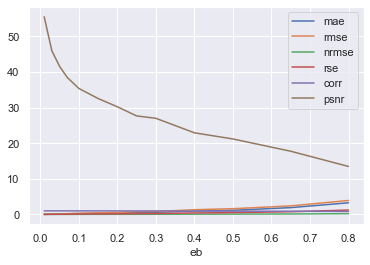

In [36]:
ettm1_baseline_results = get_baseline('arima', 'ettm1')
ettm1_forecasting_results, dec_error = get_forecasting_results(model='arima',
                                                         data_name='ettm1',
                                                         data_file='ettm1_output_data_points.parquet',
                                                         eblc_name='sz',
                                                         target_ot='OT',
                                                         ebs_values=(0.01, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50, 0.65, 0.8))
# concat_baseline_forecasting_result(baseline_results, forecasting_results, dec_error)

In [37]:
# ettm2_baseline_results = get_baseline('arima', 'ettm2')
ettm1_forecasting_results

,mae,rmse,nrmse,rse,corr,psnr
eb,,,,,,
0.01,0.085255,0.120754,0.059871,0.348868,0.941305,24.455642
0.03,0.085570,0.120839,0.059913,0.349114,0.941154,24.449519
0.05,0.086736,0.122213,0.060595,0.353085,0.939612,24.351271
0.07,0.087642,0.122768,0.060870,0.354688,0.938883,24.311931
0.10,0.090576,0.125923,0.062434,0.363804,0.935576,24.091517
0.15,0.096545,0.130552,0.064729,0.377176,0.931906,23.777989
0.20,0.099515,0.134685,0.066779,0.389118,0.927116,23.507242
0.25,0.107034,0.141998,0.070404,0.410244,0.920612,23.048021
0.30,0.109838,0.145430,0.072106,0.420160,0.918270,22.840578
